In [1]:
import os
import sys
import numpy as np
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from astropy.io import fits
from mmtwfs.wfs import *
from mmtwfs.zernike import ZernikeVector

25.2252252252 14.5945945946


<IPython.core.display.Javascript object>


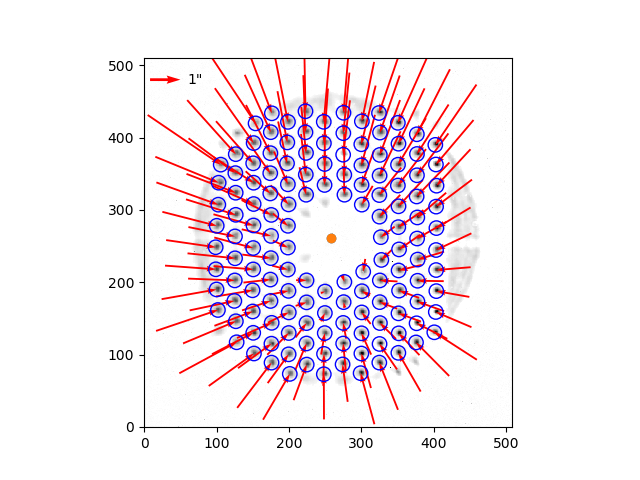

In [10]:
f9wfs = WFSFactory(wfs="f9", nzern=20, back_h=0.9)
f9_file = "/Users/tim/MMT/wfsdat/20170108/auto_wfs_0002.fits"
results = f9wfs.measure_slopes(f9_file, 'blue', plot=True)
plt.show()

Phase Amplitude Coefficients
 Z02:      18.3 nm 	 X Tilt (1, 1)
 Z03:      -148 nm 	 Y Tilt (1, -1)
 Z04:  4.09e+03 nm 	 Defocus (2, 0)
 Z05:       468 nm 	 Primary Astig at 45˚ (2, -2)
 Z06:      -411 nm 	 Primary Astig at 0˚ (2, 2)
 Z07:  -1.4e+03 nm 	 Primary Y Coma (3, -1)
 Z08:      -274 nm 	 Primary X Coma (3, 1)
 Z09:       156 nm 	 Y Trefoil (3, -3)
 Z10:       248 nm 	 X Trefoil (3, 3)
 Z11:   1.6e+03 nm 	 Primary Spherical (4, 0)
 Z12: -2.03e+03 nm 	 Secondary Astigmatism at 0˚ (4, 2)
 Z13:  2.26e+03 nm 	 Secondary Astigmatism at 45˚ (4, -2)
 Z14:      28.7 nm 	 X Tetrafoil (4, 4)
 Z15:      -191 nm 	 Y Tetrafoil (4, -4)
 Z16:      -820 nm 	 Secondary X Coma (5, 1)
 Z17: -1.86e+03 nm 	 Secondary Y Coma (5, -1)
 Z18:  1.32e+03 nm 	 Secondary X Trefoil (5, 3)
 Z19:      -114 nm 	 Secondary Y Trefoil (5, -3)
 Z20:      19.9 nm 	 X Pentafoil (5, 5)
 Z21:      -645 nm 	 Y Pentafoil (5, -5)



<IPython.core.display.Javascript object>


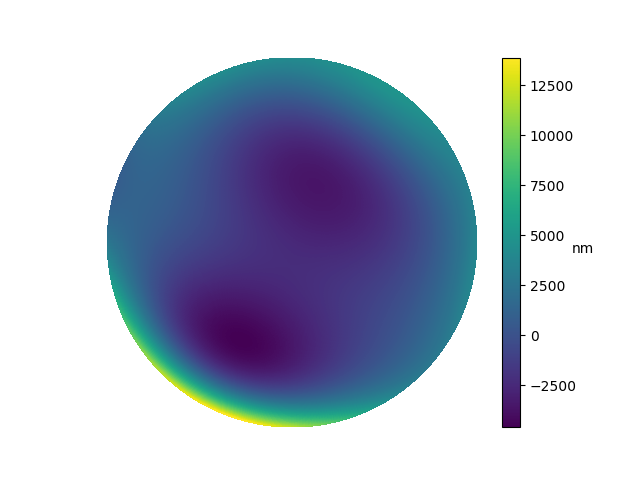

In [11]:
zv = f9wfs.fit_wavefront(results)
print(zv)
zv.ignore('Z02')
zv.ignore('Z03')
zv.plot_map()
plt.show()

29.1891891892 28.963963964


<IPython.core.display.Javascript object>


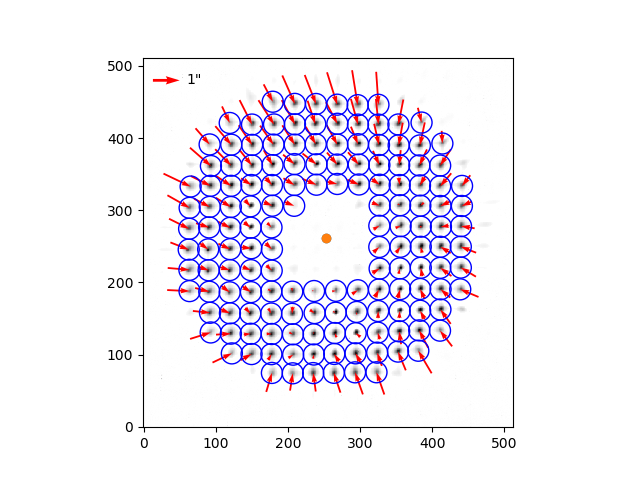

In [12]:
f5wfs = WFSFactory(wfs="f5", nzern=20, back_h=0.9)
f5_file = "/Users/tim/MMT/wfsdat/20170301/auto_wfs_0004_ave.fits"
results = f5wfs.measure_slopes(f5_file, 'hecto', plot=True)
plt.show()

Phase Amplitude Coefficients
 Z02:       -50 nm 	 X Tilt (1, 1)
 Z03:      30.1 nm 	 Y Tilt (1, -1)
 Z04:       745 nm 	 Defocus (2, 0)
 Z05:      -121 nm 	 Primary Astig at 45˚ (2, -2)
 Z06:       146 nm 	 Primary Astig at 0˚ (2, 2)
 Z07:       249 nm 	 Primary Y Coma (3, -1)
 Z08:      -413 nm 	 Primary X Coma (3, 1)
 Z09:      45.9 nm 	 Y Trefoil (3, -3)
 Z10:     -77.3 nm 	 X Trefoil (3, 3)
 Z11:     -36.7 nm 	 Primary Spherical (4, 0)
 Z12:       659 nm 	 Secondary Astigmatism at 0˚ (4, 2)
 Z13:      -529 nm 	 Secondary Astigmatism at 45˚ (4, -2)
 Z14:     -22.5 nm 	 X Tetrafoil (4, 4)
 Z15:     -18.6 nm 	 Y Tetrafoil (4, -4)
 Z16:      -543 nm 	 Secondary X Coma (5, 1)
 Z17:       246 nm 	 Secondary Y Coma (5, -1)
 Z18:      -396 nm 	 Secondary X Trefoil (5, 3)
 Z19:       228 nm 	 Secondary Y Trefoil (5, -3)
 Z20:     -96.3 nm 	 X Pentafoil (5, 5)
 Z21:     -11.7 nm 	 Y Pentafoil (5, -5)

611.5805064218027 nm


<IPython.core.display.Javascript object>


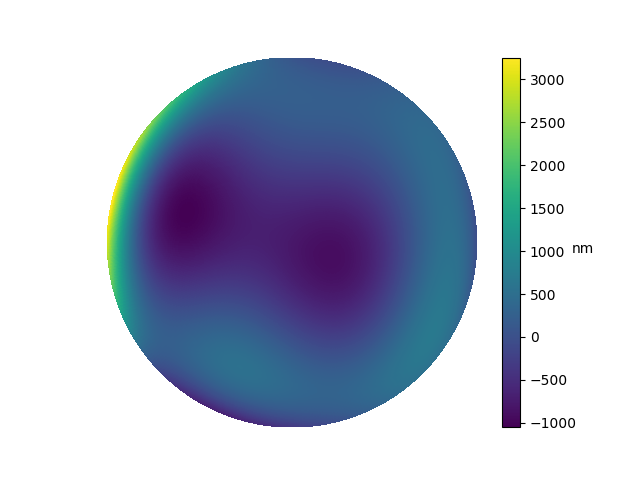

In [13]:
zv = f5wfs.fit_wavefront(results)
print(zv)
zv.ignore('Z02')
zv.ignore('Z03')
print(zv.rms)
zv.plot_map()
plt.show()

In [ ]:
mmirs = WFSFactory(wfs="mmirs", nzern=20, back_h=0.9)
mmirs_file = "/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0093.fits"
results = mmirs.measure_slopes(mmirs_file, 'mmirs2', plot=True)
plt.show()

In [ ]:
zv = mmirs.fit_wavefront(results)
print(zv)
zv.ignore('Z02')
zv.ignore('Z03')
print(zv.rms)
zv.plot_map()
plt.show()

In [ ]:
pup = f5wfs.pupil_mask(rotator=0)
plt.imshow(pup)
plt.show()

In [ ]:
im = check_wfsdata(f5_file)
back = background(im, h=0.9)
plt.imshow(im-back, origin='lower')
plt.show()

In [ ]:
subt = im - back
fits.writeto("blah.fits", subt, overwrite=True)

In [ ]:
cen = center_pupil(subt, pup, plot=True)
print(cen)
plt.show()

In [ ]:
mmirs.modes['mmirs2']['reference']['xspacing']

In [ ]:
results['xcen'], results['ycen']

In [ ]:
f5wfs.modes['hecto']['reference']

In [ ]:
f9wfs.tiltfactor

In [ ]:
mmirs.modes['mmirs2']['reference']

In [ ]:
f5wfs.modes['hecto']['reference']

In [ ]:
from mmtwfs.zernike import noll_to_zernike

In [ ]:
a = np.zeros(5)
a[2] = 1
a[3] = 1
a[4] = 0
ang = np.pi/30.
modestart = 2
a

In [ ]:
rotm = np.zeros((len(a), len(a)))

In [ ]:
for r in np.arange(len(a)):
    n_i, m_i = noll_to_zernike(r+modestart)
    for c in np.arange(len(a)):
        n_j, m_j = noll_to_zernike(c+modestart)
        delta_nij = (n_i == n_j)
        if m_i == m_j:
            rotm[r, c] = np.cos(m_j * ang)
        elif m_i == -m_j and m_i != 0.0:
            rotm[r, c] = np.sin(m_j * ang)
        elif np.abs(m_i) != np.abs(m_j):
            rotm[r, c] = 0.0
       
        rotm[r, c] *= delta_nij

In [ ]:
rotm

In [ ]:
np.dot(rotm, a)

In [ ]:
a

In [ ]:
b = np.arange(25).reshape((5,5))

In [ ]:
b

In [ ]:
b[1, 2]

In [ ]:
zv = ZernikeVector(Z05=500)

In [ ]:
zv.plot_map()
plt.show()

In [ ]:
zv.rotate(-90*u.deg)
zv.plot_map()
plt.show()

In [ ]:
zv